# Rede com contração e expansão

## Importando os módulos

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torchvision
from torchvision.datasets import MNIST

# our library
from lib import pytorch_trainer_v2 as ptt

In [2]:
# verifica se a GPU esta disponivel
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Carregando MNIST dataset

In [3]:
dataset_dir = './data/MNIST/'

# Transforma os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = torchvision.transforms.ToTensor()

# Carrega o conjunto de treinamento e de teste
datasets = dict(train=MNIST(dataset_dir, train=True,  transform=data_transform, download=False),
                val  =MNIST(dataset_dir, train=False, transform=data_transform, download=False))

dataloaders = dict(train=torch.utils.data.DataLoader(dataset=datasets['train'], batch_size=32, shuffle=True),
                   val  =torch.utils.data.DataLoader(dataset=datasets['val'],   batch_size=32, shuffle=False))

print('Amostras para treinamento:', len(datasets['train']))
print('Amostras para validação:', len(datasets['val']))
print(type(datasets['train'].train_data))
print(datasets['train'].train_data.size())
print(datasets['train'].train_data.min(), datasets['train'].train_data.max())

Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


## Definição do modelo com camadas densas

In [4]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = torch.nn.Sequential(OrderedDict([
            # lembrar de usar zero padding para manter o tamanho da imagem
            ('conv1', torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)),   
            ('relu1', torch.nn.ReLU()),
            ('max_pool1', torch.nn.MaxPool2d(2)),

            ('conv2', torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)),
            ('relu2', torch.nn.ReLU()),
            ('max_pool2', torch.nn.MaxPool2d(2)),
            
            ('drop', torch.nn.Dropout(p=0.5))
        ]))
        
        # Camadas densas
        self.dense_layer = torch.nn.Sequential(OrderedDict([
            ('dense1', torch.nn.Linear(in_features=2450, out_features=80)),
            ('relu1', torch.nn.ReLU()),
            ('dense2', torch.nn.Linear(in_features=80, out_features=10)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 2450)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x

## Treinamento

In [5]:
model_dir = './lenet-mnist'

model = MyModel().to(device)

# Calcula o erro pela CrossEntropy
criterion = torch.nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.Adam(model.parameters())

trainer = ptt.DeepNetTrainer(
    model=model, 
    criterion   = criterion, 
    optimizer   = optimizer,
    # Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
    lr_scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    callbacks   = [ptt.AccuracyMetric(),
                   ptt.PrintCallback(),
                   ptt.ModelCheckpoint(model_dir, reset=True, verbose=1)
                  ],
    devname     = device
)

In [6]:
retrain = True
if retrain:
    trainer.fit_loader(n_epochs=10, train_data=dataloaders['train'], valid_data=dataloaders['val'])
else:
    trainer.load_state(model_dir)

Start training for 10 epochs
  1:  14.2s   T: 0.00510 *  0.94928 *   V: 0.00190 *  0.98060 *  
  2:  13.4s   T: 0.00193 *  0.98008     V: 0.00143 *  0.98600    
  3:  13.6s   T: 0.00156 *  0.98407     V: 0.00122 *  0.98680    
  4:  13.5s   T: 0.00124 *  0.98760     V: 0.00163    0.98180    
  5:  13.4s   T: 0.00112 *  0.98858     V: 0.00111 *  0.98860    
  6:  13.4s   T: 0.00096 *  0.98992     V: 0.00105 *  0.99010    
  7:  13.4s   T: 0.00084 *  0.99105     V: 0.00140    0.98790    
  8:  13.4s   T: 0.00054 *  0.99457     V: 0.00086 *  0.99170    
  9:  13.4s   T: 0.00041 *  0.99582     V: 0.00089    0.99150    
 10:  13.4s   T: 0.00036 *  0.99632     V: 0.00087    0.99210    
Stop training at epoch: 10/10
Best model was saved at epoch 8 with loss 0.00086: ./lenet-mnist


In [7]:
preds_dense = trainer.predict_classes_loader(dataloaders['val'])

In [8]:
preds = trainer.predict_loader( dataloaders['val'])
preds.shape

torch.Size([10000, 10])

## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

A primeira camada densa do modelo tem como entrada um tensor de dimensão 2450, resultante do redimensionamento (via *Flatten*) da saída do *Dropout*, 50x7x7. Esta camada gera uma saída com dimensão 50. Seus pesos têm portanto dimensão 2450x50.

Uma camada convolucional que substitua estas camadas *Flatten* e *Dense* terá como entrada um tensor 50x7x7. Para gerar uma saída 50x1x1, a convolução deve criar 50 mapas com um kernel 7x7 e com borda do tipo 'valid'.

Para substituir a última camada densa, usamos uma convolução com 10 mapas e kernel 1x1.


In [9]:
class MyModelFullyConv(torch.nn.Module):
    def __init__(self):
        super(MyModelFullyConv, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = torch.nn.Sequential(OrderedDict([
            # lembrar de usar zero padding para manter o tamanho da imagem
            ('conv1', torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)),   
            ('relu1', torch.nn.ReLU()),
            ('max_pool1', torch.nn.MaxPool2d(2)),

            ('conv2', torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)),
            ('relu2', torch.nn.ReLU()),
            ('max_pool2', torch.nn.MaxPool2d(2)),
            
            ('conv3', torch.nn.Conv2d(in_channels=50, out_channels=80, kernel_size=7)),
            ('relu3', torch.nn.ReLU()),
            
            ('conv4', torch.nn.Conv2d(in_channels=80, out_channels=10, kernel_size=1)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)        
        return x

### Observando a saida de cada camada

In [10]:
model_conv = MyModelFullyConv().to(device)
x = torch.autograd.Variable(torch.zeros(1, 1, 28, 28)).to(device)

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_conv.conv_layer.named_children():
    x = layer(x)
    print('{:10}: {}'.format(name, str(x.size())))

input     : torch.Size([1, 1, 28, 28])
conv1     : torch.Size([1, 20, 28, 28])
relu1     : torch.Size([1, 20, 28, 28])
max_pool1 : torch.Size([1, 20, 14, 14])
conv2     : torch.Size([1, 50, 14, 14])
relu2     : torch.Size([1, 50, 14, 14])
max_pool2 : torch.Size([1, 50, 7, 7])
conv3     : torch.Size([1, 80, 1, 1])
relu3     : torch.Size([1, 80, 1, 1])
conv4     : torch.Size([1, 10, 1, 1])


### comparando o tamanho dos pesos das duas redes

In [11]:
def print_weights_size(weight_dict):
    for name, weight in weight_dict.items():
        print('{:25} -> {}'.format(name, weight.shape))

In [13]:
print('--Pesos no modelo dense--')
print_weights_size(model.state_dict())
print('\n--Pesos no modelo fully convolutional--')
print_weights_size(model_conv.state_dict())

--Pesos no modelo dense--
conv_layer.conv1.weight   -> torch.Size([20, 1, 5, 5])
conv_layer.conv1.bias     -> torch.Size([20])
conv_layer.conv2.weight   -> torch.Size([50, 20, 5, 5])
conv_layer.conv2.bias     -> torch.Size([50])
dense_layer.dense1.weight -> torch.Size([80, 2450])
dense_layer.dense1.bias   -> torch.Size([80])
dense_layer.dense2.weight -> torch.Size([10, 80])
dense_layer.dense2.bias   -> torch.Size([10])

--Pesos no modelo fully convolutional--
conv_layer.conv1.weight   -> torch.Size([20, 1, 5, 5])
conv_layer.conv1.bias     -> torch.Size([20])
conv_layer.conv2.weight   -> torch.Size([50, 20, 5, 5])
conv_layer.conv2.bias     -> torch.Size([50])
conv_layer.conv3.weight   -> torch.Size([80, 50, 7, 7])
conv_layer.conv3.bias     -> torch.Size([80])
conv_layer.conv4.weight   -> torch.Size([10, 80, 1, 1])
conv_layer.conv4.bias     -> torch.Size([10])


## Ajustando os pesos do modelo todo convolucional

In [14]:
w_dense = model.state_dict()
w_conv  = model_conv.state_dict()

# Só precisamos ajustar as dimensões dos pesos das camadas:
# - dense1.weight para o tamanho de conv3.weight
# - dense2.weight para o tamanho de conv4.weight
# As outras camadas serão somente copiadas

# weigths
w_conv['conv_layer.conv1.weight'] = w_dense['conv_layer.conv1.weight']
w_conv['conv_layer.conv2.weight'] = w_dense['conv_layer.conv2.weight']
w_conv['conv_layer.conv3.weight'] = w_dense['dense_layer.dense1.weight'].view(80, 50, 7, 7)
w_conv['conv_layer.conv4.weight'] = w_dense['dense_layer.dense2.weight'].view(10, 80, 1, 1)

# bias
w_conv['conv_layer.conv1.bias'] = w_dense['conv_layer.conv1.bias']
w_conv['conv_layer.conv2.bias'] = w_dense['conv_layer.conv2.bias']
w_conv['conv_layer.conv3.bias'] = w_dense['dense_layer.dense1.bias']
w_conv['conv_layer.conv4.bias'] = w_dense['dense_layer.dense2.bias']

model_conv.load_state_dict(w_conv)

## Verificando se o desempenho é o mesmo

Uma vez que colocamos na rede B os pesos da rede A, precisamos verificar se o desempenho da rede B (totalmente convolucional)
possui o mesmo desempenho da rede A.
Fazermos isso medindo a acurácia das duas redes no conjunto de testes.

In [15]:
preds_conv_img = trainer.predict_classes_loader(dataloaders['val'])
preds_conv = torch.squeeze(preds_conv_img)

In [16]:
# Mostra os 10 primeiros elementos preditos
labels = datasets['val'].test_labels

print('{:6}: {}'.format('labels',     labels[:10].numpy()))
print('{:6}: {}'.format('dense', preds_dense[:10].numpy()))
print('{:6}: {}'.format('conv',   preds_conv[:10].numpy()))

labels: [7 2 1 0 4 1 4 9 5 9]
dense : [7 2 1 0 4 1 4 9 5 9]
conv  : [7 2 1 0 4 1 4 9 5 9]


In [17]:
print('Acurácia rede totalmente convolucional: {}%'.format(100.0 *(preds_conv  == labels).sum() / labels.shape[0]))
print('Acurácia rede clássica:                 {}%'.format(100.0 *(preds_dense == labels).sum() / labels.shape[0]))

Acurácia rede totalmente convolucional: 99%
Acurácia rede clássica:                 99%


# Aplicando o classificador numa imagem maior que 28x28

In [18]:
# Função para criar uma imagem de teste, maior que 28x28 colocando várias amostras
def make_image(X_test, y_test, M=200, H=28, W=28):
    char_index = np.random.choice(X_test.shape[0], 10, replace=False)
    char_img = [img.reshape(H,W) for img in (X_test)[char_index]]
    char_lab = [y for y in y_test[char_index]]

    image = np.zeros((M, M), np.uint8)
    coords = [(20, 20), (50, 150), (100, 100), (151, 151), (120,30)] # posição das imagens na imagem maior
    xlabel = []
    for k, (i, j) in enumerate(coords):
        image[i:i+H, j:j+W] = char_img[k]
        xlabel.append(char_lab[k])
    return image, coords, xlabel

In [19]:
labels = datasets['val'].test_labels
x_test = datasets['val'].test_data

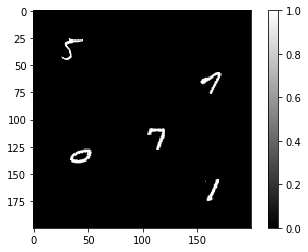

In [20]:
M = 200
image_uint8, coords, xlabel = make_image(x_test.numpy(), labels.numpy(), M) # Construindo uma imagem para testes M x M com 4 dígitos
image = image_uint8/255.
plt.imshow(image, cmap='gray')
plt.colorbar()

## Aplicando classificador na imagem 200 x 200

In [21]:
# transforma imagem de input em Tensor e em seguida a coloca em uma variável
in_image = image.reshape(1, 1, M, M)
in_image = torch.from_numpy(in_image).type(torch.FloatTensor).to(device)
#in_image = torch.autograd.Variable(in_image)

print('{:30}{}'.format('tamanho na entrada:', in_image.size()))
probs = ptt.predict_probas(model_conv, in_image)

output = model_conv(torch.autograd.Variable(in_image))
po = torch.nn.functional.softmax(output,dim=1)
max_pred, max_class = torch.max(po, dim=1)

max_pred_pad = torch.nn.functional.pad(max_pred.view(44,44),(3,3,3,3))
print('{:30}{}'.format('tamanho na saída:', max_pred.shape))
print('{:30}{}'.format('tamanho após o padding:', max_pred_pad.shape))

tamanho na entrada:           torch.Size([1, 1, 200, 200])
tamanho na saída:             torch.Size([1, 44, 44])
tamanho após o padding:       torch.Size([50, 50])


In [22]:
hot_map = max_pred_pad.data.cpu().numpy()
print('{:30}{}'.format('tamanho do hot map:', hot_map.shape))

tamanho do hot map:           (50, 50)


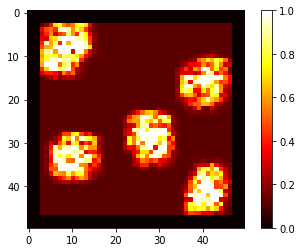

In [23]:
plt.imshow(hot_map, plt.cm.hot)
plt.colorbar()
plt.show()

### Supressão de valores não máximos

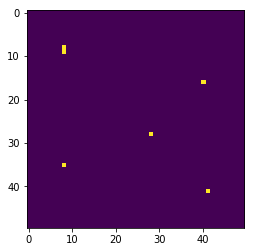

In [24]:
import skimage
from skimage.morphology import square
disk = square(11)
disk[5,5]=0
dil = skimage.morphology.dilation(np.clip(hot_map,0.6,1.0),disk)
cc = hot_map >= dil
plt.imshow(cc)

### Classe identificada em cada máximo

In [25]:
max_class_pad = torch.nn.functional.pad(max_class.view(44,44),(3,3,3,3)).data.cpu().numpy()

for r,c in np.transpose(np.nonzero(cc)):
    print(r,c,hot_map[r,c],max_class_pad[r,c])

8 8 1.0 5
9 8 1.0 5
16 40 0.99988985 7
28 28 1.0 7
35 8 0.99999905 5
41 41 0.9999943 1


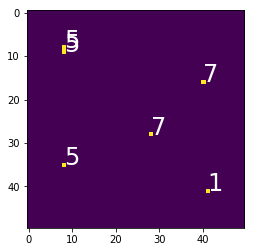

In [26]:
plt.imshow(cc)
for r,c in np.transpose(np.nonzero(cc)):
    plt.text(c,r,max_class_pad[r,c] ,color='white', fontsize=24)
plt.show()

## Rede com contração e expansão

In [27]:
class MyModelContractExpand(torch.nn.Module):
    def __init__(self):
        super(MyModelContractExpand, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)
        self.relu1 = torch.nn.ReLU()
        self.max_pool1 = torch.nn.MaxPool2d(2, return_indices=True)

        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)
        self.relu2 = torch.nn.ReLU()
        self.max_pool2 = torch.nn.MaxPool2d(2, return_indices=True)

        self.relu3 = torch.nn.ReLU()

        self.max_unpool2 = torch.nn.MaxUnpool2d(2)
        self.relu4 = torch.nn.ReLU()
        self.transp2 = torch.nn.ConvTranspose2d(in_channels=50, out_channels=20, kernel_size=5, padding=2)

        self.max_unpool1 = torch.nn.MaxUnpool2d(2)
        self.relu5 = torch.nn.ReLU()
        self.transp1 = torch.nn.ConvTranspose2d(in_channels=20, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x, indices1 = self.max_pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x, indices2 = self.max_pool2(x)

        x = self.relu3(x)

        x = self.max_unpool2(x, indices2)
        x = self.relu4(x)
        x = self.transp2(x)

        x = self.max_unpool1(x, indices1)
        x = self.relu5(x)
        x = self.transp1(x)

        return x

### Observando a saida de cada camada

In [28]:
model_contract_expand = MyModelContractExpand().to(device)
x = torch.autograd.Variable(torch.zeros(1, 1, 28, 28)).to(device)
inds = list()
ind_idx = 0

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_contract_expand.named_children():
    if 'max_pool' in name:
        x, inds_tensor = layer(x)
        inds.append(inds_tensor)
        ind_idx += 1
    elif 'max_unpool' in name:
        ind_idx -= 1
        x = layer(x, inds[ind_idx])
    else:
        x = layer(x)

    print('{:10}: {}'.format(name, str(x.size())))

input     : torch.Size([1, 1, 28, 28])
conv1     : torch.Size([1, 20, 28, 28])
relu1     : torch.Size([1, 20, 28, 28])
max_pool1 : torch.Size([1, 20, 14, 14])
conv2     : torch.Size([1, 50, 14, 14])
relu2     : torch.Size([1, 50, 14, 14])
max_pool2 : torch.Size([1, 50, 7, 7])
relu3     : torch.Size([1, 50, 7, 7])
max_unpool2: torch.Size([1, 50, 14, 14])
relu4     : torch.Size([1, 50, 14, 14])
transp2   : torch.Size([1, 20, 14, 14])
max_unpool1: torch.Size([1, 20, 28, 28])
relu5     : torch.Size([1, 20, 28, 28])
transp1   : torch.Size([1, 1, 28, 28])


### comparando o tamanho dos pesos das duas redes

In [29]:
print('\n--Pesos no modelo fully convolutional--')
print_weights_size(model_conv.state_dict())
print('--Pesos no modelo com contração e expansão--')
print_weights_size(model_contract_expand.state_dict())


--Pesos no modelo fully convolutional--
conv_layer.conv1.weight   -> torch.Size([20, 1, 5, 5])
conv_layer.conv1.bias     -> torch.Size([20])
conv_layer.conv2.weight   -> torch.Size([50, 20, 5, 5])
conv_layer.conv2.bias     -> torch.Size([50])
conv_layer.conv3.weight   -> torch.Size([80, 50, 7, 7])
conv_layer.conv3.bias     -> torch.Size([80])
conv_layer.conv4.weight   -> torch.Size([10, 80, 1, 1])
conv_layer.conv4.bias     -> torch.Size([10])
--Pesos no modelo com contração e expansão--
conv1.weight              -> torch.Size([20, 1, 5, 5])
conv1.bias                -> torch.Size([20])
conv2.weight              -> torch.Size([50, 20, 5, 5])
conv2.bias                -> torch.Size([50])
transp2.weight            -> torch.Size([50, 20, 5, 5])
transp2.bias              -> torch.Size([20])
transp1.weight            -> torch.Size([20, 1, 5, 5])
transp1.bias              -> torch.Size([1])


## Ajustando os pesos do modelo com contração e expansão

In [30]:
w_conv  = model_conv.state_dict()
w_contract_expand  = model_contract_expand.state_dict()

# weigths
w_contract_expand['conv1.weight'] = w_conv['conv_layer.conv1.weight']
w_contract_expand['conv2.weight'] = w_conv['conv_layer.conv2.weight']
w_contract_expand['transp1.weight'] = w_conv['conv_layer.conv1.weight']
w_contract_expand['transp2.weight'] = w_conv['conv_layer.conv2.weight']

# bias
w_contract_expand['conv1.bias'] = w_conv['conv_layer.conv1.bias']
w_contract_expand['conv2.bias'] = w_conv['conv_layer.conv2.bias']
w_contract_expand['transp1.bias'] = w_conv['conv_layer.conv1.bias'].mean(0, keepdim=True)
w_contract_expand['transp2.bias'] = w_conv['conv_layer.conv1.bias']

model_contract_expand.load_state_dict(w_contract_expand)

## Aplicando o classificador numa imagem maior que 28x28

In [31]:
def gaussianMap(H=28, W=28, sigma=1.0, mu=0.0, denorm=1.0):
    x, y = np.meshgrid(np.linspace(-1,1,W), np.linspace(-1,1,H))
    d = np.sqrt(x*x+y*y)
    return np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) ) * denorm

In [32]:
gm = gaussianMap(H=4, W=6)
print(gm)

[[0.36787944 0.50661699 0.59452055 0.59452055 0.50661699 0.36787944]
 [0.57375342 0.79013177 0.92722822 0.92722822 0.79013177 0.57375342]
 [0.57375342 0.79013177 0.92722822 0.92722822 0.79013177 0.57375342]
 [0.36787944 0.50661699 0.59452055 0.59452055 0.50661699 0.36787944]]


In [33]:
gm = gaussianMap(H=15, W=15, sigma=0.5, denorm=255.0)
print(gm.astype('uint8'))

[[  4   7  12  17  23  29  33  34  33  29  23  17  12   7   4]
 [  7  13  21  30  40  49  56  58  56  49  40  30  21  13   7]
 [ 12  21  33  47  63  78  88  91  88  78  63  47  33  21  12]
 [ 17  30  47  69  91 112 127 132 127 112  91  69  47  30  17]
 [ 23  40  63  91 122 150 169 176 169 150 122  91  63  40  23]
 [ 29  49  78 112 150 183 207 216 207 183 150 112  78  49  29]
 [ 33  56  88 127 169 207 235 244 235 207 169 127  88  56  33]
 [ 34  58  91 132 176 216 244 255 244 216 176 132  91  58  34]
 [ 33  56  88 127 169 207 235 244 235 207 169 127  88  56  33]
 [ 29  49  78 112 150 183 207 216 207 183 150 112  78  49  29]
 [ 23  40  63  91 122 150 169 176 169 150 122  91  63  40  23]
 [ 17  30  47  69  91 112 127 132 127 112  91  69  47  30  17]
 [ 12  21  33  47  63  78  88  91  88  78  63  47  33  21  12]
 [  7  13  21  30  40  49  56  58  56  49  40  30  21  13   7]
 [  4   7  12  17  23  29  33  34  33  29  23  17  12   7   4]]


In [34]:
# Função para criar uma imagem de teste, maior que 28x28 colocando várias amostras
def make_image_heat_map(X_test, y_test, M=200, H=28, W=28):
    char_index = np.random.choice(X_test.shape[0], 10, replace=False)
    char_img = [img.reshape(H,W) for img in (X_test)[char_index]]
    char_lab = [y for y in y_test[char_index]]
    gm = gaussianMap(H=H, W=W, sigma=0.5, denorm=255.0).astype('uint8')

    image = np.zeros((M, M), np.uint8)
    heat_map = np.zeros((M, M), np.uint8)
    coords = [(20, 20), (50, 150), (100, 100), (151, 151), (120,30)] # posição das imagens na imagem maior
    xlabel = []
    for k, (i, j) in enumerate(coords):
        image[i:i+H, j:j+W] = char_img[k]
        heat_map[i:i+H, j:j+W] = gm
        xlabel.append(char_lab[k])
    return image, heat_map, coords, xlabel

In [35]:
def print_weights_size(weight_dict):
    for name, weight in weight_dict.items():
        print('{:25} -> {}'.format(name, weight.shape))

In [36]:
labels = datasets['val'].test_labels
x_test = datasets['val'].test_data

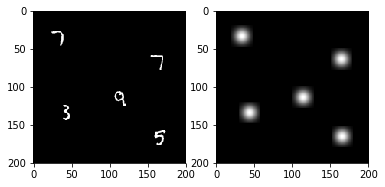

In [37]:
M = 200

# Construindo uma imagem para testes M x M com 5 dígitos
image_uint8, heat_map_uint8, coords, xlabel = make_image_heat_map(x_test.numpy(), labels.numpy(), M)
image = image_uint8/255.
heat_map = heat_map_uint8/255.

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image, cmap='gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(heat_map, cmap='gray')

## Aplicando classificador na imagem 200 x 200

In [38]:
# transforma imagem e heat map em Tensores e em seguida a coloca em uma variável
in_image = image.reshape(1, 1, M, M)
in_heat_map = heat_map.reshape(1, 1, M, M)

in_image = torch.from_numpy(in_image).type(torch.FloatTensor).to(device)
in_heat_map = torch.from_numpy(in_heat_map).type(torch.FloatTensor).to(device)

#in_image = torch.autograd.Variable(in_image)
#in_heat_map = torch.autograd.Variable(in_heat_map)

print('{:30}{}'.format('tamanho da image:', in_image.size()))
print('{:30}{}'.format('tamanho do heat map:', in_heat_map.size()))
probs = ptt.predict_probas(model_contract_expand, in_image)

output = model_contract_expand(torch.autograd.Variable(in_image))

print('{:30}{}'.format('tamanho na saída:', output.shape))

tamanho da image:             torch.Size([1, 1, 200, 200])
tamanho do heat map:          torch.Size([1, 1, 200, 200])
tamanho na saída:             torch.Size([1, 1, 200, 200])


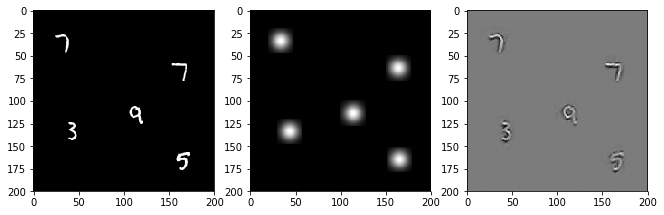

In [41]:
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(in_image[0][0].cpu().numpy(), cmap='gray')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(in_heat_map[0][0].cpu().numpy(), cmap='gray')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(output[0][0].cpu().detach().numpy(), cmap='gray')